In [124]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from imblearn.over_sampling import SMOTE
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [125]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

Using device: cuda


In [126]:
data_path = Path('../data/processed/processed.csv')
model_dir = Path('../models')
model_dir.mkdir(exist_ok=True)

In [127]:
df = pd.read_csv(data_path)
print(f"Loaded dataset: {df.shape}")

Loaded dataset: (503, 61)


In [128]:
target_col = 'ESG Risk Level'
exclude_cols = ['Symbol', 'Name', 'Address', 'Description', 'Sector', 'Industry', 
                'Controversy Level', 'ESG Risk Level', 'ESG Risk Percentile', 'Employee Size']
leakage_features = [
    'ESG_Component_Balance', 'ESG_Max_Component', 'ESG_Min_Component',
    'ESG_Risk_Above_Average', 'ESG_Risk_Category', 'Sector_Risk_Average',
    'ESG_vs_Sector_Average', 'High_Risk_Percentile', 'ESG Risk Percentile_Encoded',
    'ESG Risk Level_High', 'ESG Risk Level_Low', 'ESG Risk Level_Medium',
    'ESG Risk Level_Negligible', 'ESG Risk Level_Severe', 'ESG Risk Level_nan',
    'ESG_Risk_Category_Low', 'ESG_Risk_Category_Medium', 'ESG_Risk_Category_High',
    'ESG_Risk_Category_Severe', 'ESG_Risk_Category_nan'
]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [col for col in numeric_cols if col not in exclude_cols and col not in leakage_features]

In [129]:
X = df[feature_cols].copy()
y = df[target_col].copy()
X = X.fillna(0)
y = y.fillna('Medium')
print(f"Features: {len(feature_cols)}")
print(f"Target distribution:\n{y.value_counts()}")

Features: 31
Target distribution:
Low           260
Medium        184
High           50
Negligible      6
Severe          3
Name: ESG Risk Level, dtype: int64


In [130]:
label_mapping = {'Low': 0, 'Negligible': 0, 'Medium': 1, 'High': 2, 'Severe': 2}
y_encoded = y.map(label_mapping)
y_encoded = y_encoded.fillna(1).astype(int)
num_classes = len(y_encoded.unique())
print(f"Classes: {sorted(y_encoded.unique())}")
print(f"Class distribution:\n{y_encoded.value_counts().sort_index()}")

Classes: [0, 1, 2]
Class distribution:
0    266
1    184
2     53
Name: ESG Risk Level, dtype: int64


In [131]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y_encoded, test_size=0.15, random_state=RANDOM_SEED, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.176, random_state=RANDOM_SEED, stratify=y_temp
)
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Train: (351, 31), Val: (76, 31), Test: (76, 31)


In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [133]:
smote = SMOTE(random_state=RANDOM_SEED, k_neighbors=3)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)
print(f"Original training set: {X_train_scaled.shape}")
print(f"Resampled training set: {X_train_resampled.shape}")
print(f"Class distribution after SMOTE:\\n{pd.Series(y_train_resampled).value_counts().sort_index()}")


Original training set: (351, 31)
Resampled training set: (558, 31)
Class distribution after SMOTE:\n0    186
1    186
2    186
Name: ESG Risk Level, dtype: int64


In [134]:
X_train_tensor = torch.FloatTensor(X_train_resampled)
y_train_tensor = torch.LongTensor(y_train_resampled)
X_val_tensor = torch.FloatTensor(X_val_scaled)
y_val_tensor = torch.LongTensor(y_val.values)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.LongTensor(y_test.values)

In [135]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

In [136]:
class ESGRiskClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.5):
        super(ESGRiskClassifier, self).__init__()
        layers = []
        prev_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            prev_dim = hidden_dim
        layers.append(nn.Linear(prev_dim, num_classes))
        self.network = nn.Sequential(*layers)
    def forward(self, x):
        return self.network(x)

In [137]:
input_dim = X_train_scaled.shape[1]
hidden_dims = [512, 256, 128]
model = ESGRiskClassifier(input_dim, hidden_dims, num_classes, dropout=0.4).to(device)
print(f"Model architecture:\n{model}")
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model architecture:
ESGRiskClassifier(
  (network): Sequential(
    (0): Linear(in_features=31, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.4, inplace=False)
    (12): Linear(in_features=128, out_features=3, bias=True)
  )
)

Total parameters: 182,787
Trainable parameters: 182,787


In [138]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing
    def forward(self, inputs, targets):
        if self.label_smoothing > 0:
            n_classes = inputs.size(1)
            targets_one_hot = F.one_hot(targets, n_classes).float()
            targets_smooth = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / n_classes
            ce_loss = -(targets_smooth * F.log_softmax(inputs, dim=1)).sum(dim=1)
        else:
            ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss
        if self.alpha is not None and self.label_smoothing == 0:
            alpha_t = self.alpha[targets]
            focal_loss = alpha_t * focal_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [139]:
class_counts = torch.bincount(y_train_tensor)
class_weights = 1.0 / class_counts.float()
class_weights = class_weights / class_weights.sum() * len(class_weights)
class_weights = class_weights.to(device)
criterion = FocalLoss(alpha=class_weights, gamma=2.0, label_smoothing=0.1)
print(f"Using Focal Loss with label smoothing=0.1 and gamma=2.0")

Using Focal Loss with label smoothing=0.1 and gamma=2.0


In [140]:
def train_with_config(batch_size, learning_rate, weight_decay, num_epochs):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    model_instance = ESGRiskClassifier(input_dim, hidden_dims, num_classes, dropout=0.4).to(device)
    optimizer = optim.AdamW(model_instance.parameters(), lr=learning_rate, weight_decay=weight_decay)
    steps_per_epoch = len(train_loader)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=learning_rate * 10,
        epochs=num_epochs,
        steps_per_epoch=steps_per_epoch,
        pct_start=0.3,
        anneal_strategy='cos'
    )
    best_val_loss = float('inf')
    best_val_acc = 0.0
    patience_counter = 0
    early_stop_patience = 15
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    for epoch in range(num_epochs):
        model_instance.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model_instance(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_instance.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()  # Step per batch for OneCycleLR
            train_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += batch_y.size(0)
            train_correct += (predicted == batch_y).sum().item()
        model_instance.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model_instance(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += batch_y.size(0)
                val_correct += (predicted == batch_y).sum().item()
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_val_acc = val_acc
            patience_counter = 0
        else:
            patience_counter += 1
        if patience_counter >= early_stop_patience:
            break
    return best_val_loss, best_val_acc, model_instance, train_losses, val_losses, train_accs, val_accs

In [141]:
hyperparameter_grid = {
    'batch_size': [32, 64],
    'learning_rate': [0.0001, 0.0002],  # Reduced search space for faster testing
    'weight_decay': [1e-4, 5e-4],
    'num_epochs': [150]  # OneCycleLR converges faster
}

In [142]:
best_config = None
best_val_loss = float('inf')
best_model_state = None
results = []
best_curves = None
for batch_size in hyperparameter_grid['batch_size']:
    for lr in hyperparameter_grid['learning_rate']:
        for wd in hyperparameter_grid['weight_decay']:
            for epochs in hyperparameter_grid['num_epochs']:
                print(f"\nTesting: bs={batch_size}, lr={lr}, wd={wd}, epochs={epochs}")
                val_loss, val_acc, trained_model, train_losses, val_losses, train_accs, val_accs = train_with_config(
                    batch_size, lr, wd, epochs
                )
                print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                results.append({
                    'batch_size': batch_size,
                    'learning_rate': lr,
                    'weight_decay': wd,
                    'num_epochs': epochs,
                    'val_loss': val_loss,
                    'val_acc': val_acc
                })
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_config = {
                        'batch_size': batch_size,
                        'learning_rate': lr,
                        'weight_decay': wd,
                        'num_epochs': epochs
                    }
                    best_model_state = trained_model.state_dict()
                    best_curves = {
                        'train_losses': train_losses,
                        'val_losses': val_losses,
                        'train_accs': train_accs,
                        'val_accs': val_accs
                    }
print(f"\nBest configuration: {best_config}")
print(f"Best validation loss: {best_val_loss:.4f}")


Testing: bs=32, lr=0.0001, wd=0.0001, epochs=150
Val Loss: 0.2252, Val Acc: 0.7895

Testing: bs=32, lr=0.0001, wd=0.0005, epochs=150
Val Loss: 0.2188, Val Acc: 0.8158

Testing: bs=32, lr=0.0002, wd=0.0001, epochs=150
Val Loss: 0.2233, Val Acc: 0.7895

Testing: bs=32, lr=0.0002, wd=0.0005, epochs=150
Val Loss: 0.2223, Val Acc: 0.7763

Testing: bs=64, lr=0.0001, wd=0.0001, epochs=150
Val Loss: 0.2272, Val Acc: 0.7763

Testing: bs=64, lr=0.0001, wd=0.0005, epochs=150
Val Loss: 0.2185, Val Acc: 0.7895

Testing: bs=64, lr=0.0002, wd=0.0001, epochs=150
Val Loss: 0.2440, Val Acc: 0.8026

Testing: bs=64, lr=0.0002, wd=0.0005, epochs=150
Val Loss: 0.2350, Val Acc: 0.8158

Best configuration: {'batch_size': 64, 'learning_rate': 0.0001, 'weight_decay': 0.0005, 'num_epochs': 150}
Best validation loss: 0.2185


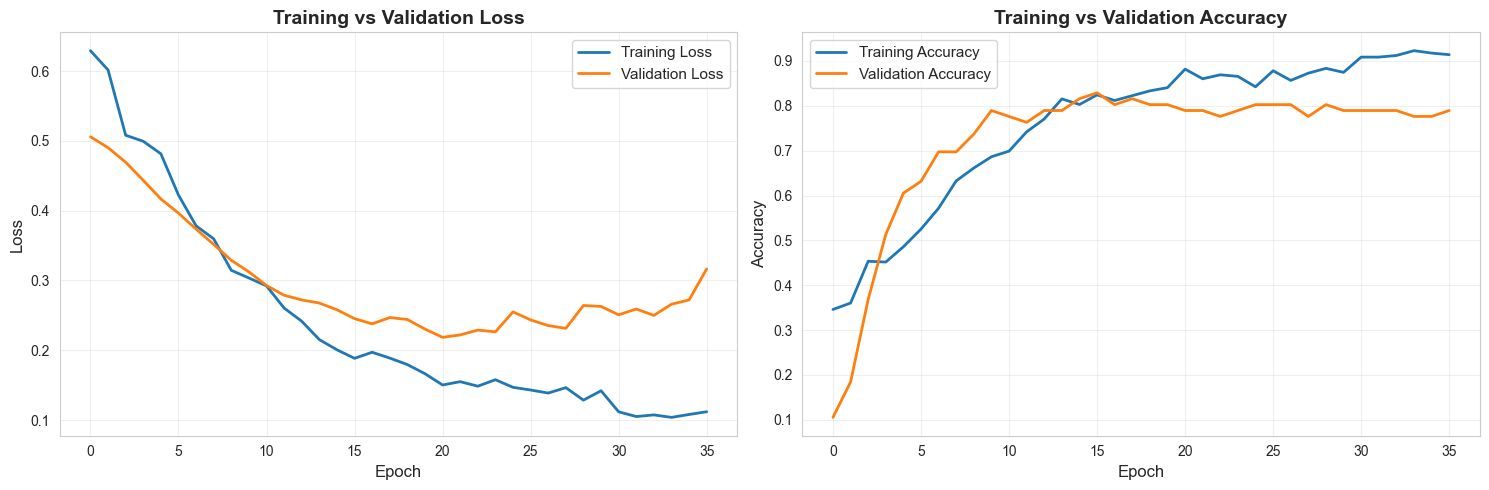

Training curves saved to ..\models\training_curves.png


In [143]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].plot(best_curves['train_losses'], label='Training Loss', linewidth=2)
axes[0].plot(best_curves['val_losses'], label='Validation Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training vs Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[1].plot(best_curves['train_accs'], label='Training Accuracy', linewidth=2)
axes[1].plot(best_curves['val_accs'], label='Validation Accuracy', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy', fontsize=12)
axes[1].set_title('Training vs Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(model_dir / 'training_curves.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"Training curves saved to {model_dir / 'training_curves.png'}")

In [144]:
X_full_train = pd.concat([X_train, X_val], axis=0)
y_full_train = pd.concat([y_train, y_val], axis=0)
X_full_train_scaled = scaler.fit_transform(X_full_train)
X_full_train_tensor = torch.FloatTensor(X_full_train_scaled)
y_full_train_tensor = torch.LongTensor(y_full_train.values)
full_train_dataset = TensorDataset(X_full_train_tensor, y_full_train_tensor)
print(f"Retraining on full training set: {X_full_train.shape[0]} samples")

Retraining on full training set: 427 samples


In [145]:
final_model = ESGRiskClassifier(input_dim, hidden_dims, num_classes, dropout=0.5).to(device)
optimizer = optim.AdamW(final_model.parameters(), 
                        lr=best_config['learning_rate'], 
                        weight_decay=best_config['weight_decay'])
train_loader = DataLoader(full_train_dataset, batch_size=best_config['batch_size'], shuffle=True)
steps_per_epoch = len(train_loader)
total_epochs = best_config['num_epochs'] + 50
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, 
    max_lr=best_config['learning_rate'] * 10,
    epochs=total_epochs,
    steps_per_epoch=steps_per_epoch,
    pct_start=0.3,
    anneal_strategy='cos'
)
best_train_loss = float('inf')
best_model_checkpoint = None
patience_counter = 0
early_stop_patience = 20
final_train_losses = []
final_train_accs = []
for epoch in range(total_epochs):
    final_model.train()
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = final_model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(final_model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        train_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs.data, 1)
        train_total += batch_y.size(0)
        train_correct += (predicted == batch_y).sum().item()
    train_loss = train_loss / train_total
    train_acc = train_correct / train_total
    final_train_losses.append(train_loss)
    final_train_accs.append(train_acc)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{total_epochs}] Loss: {train_loss:.4f}, Acc: {train_acc:.4f}")
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_model_checkpoint = final_model.state_dict().copy()
        patience_counter = 0
    else:
        patience_counter += 1
    if patience_counter >= early_stop_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break
if best_model_checkpoint is not None:
    final_model.load_state_dict(best_model_checkpoint)
    print(f"Loaded best checkpoint with train loss: {best_train_loss:.4f}")
final_model.eval()
print(f"Final model trained on {X_full_train.shape[0]} samples")

Epoch [20/200] Loss: 0.2894, Acc: 0.7143
Epoch [40/200] Loss: 0.1667, Acc: 0.8384
Epoch [60/200] Loss: 0.1278, Acc: 0.8782
Epoch [80/200] Loss: 0.1171, Acc: 0.8946
Epoch [100/200] Loss: 0.0902, Acc: 0.9204
Epoch [120/200] Loss: 0.0806, Acc: 0.9251
Epoch [140/200] Loss: 0.0781, Acc: 0.9415
Epoch [160/200] Loss: 0.0613, Acc: 0.9508
Epoch [180/200] Loss: 0.0685, Acc: 0.9461
Early stopping at epoch 185
Loaded best checkpoint with train loss: 0.0543
Final model trained on 427 samples


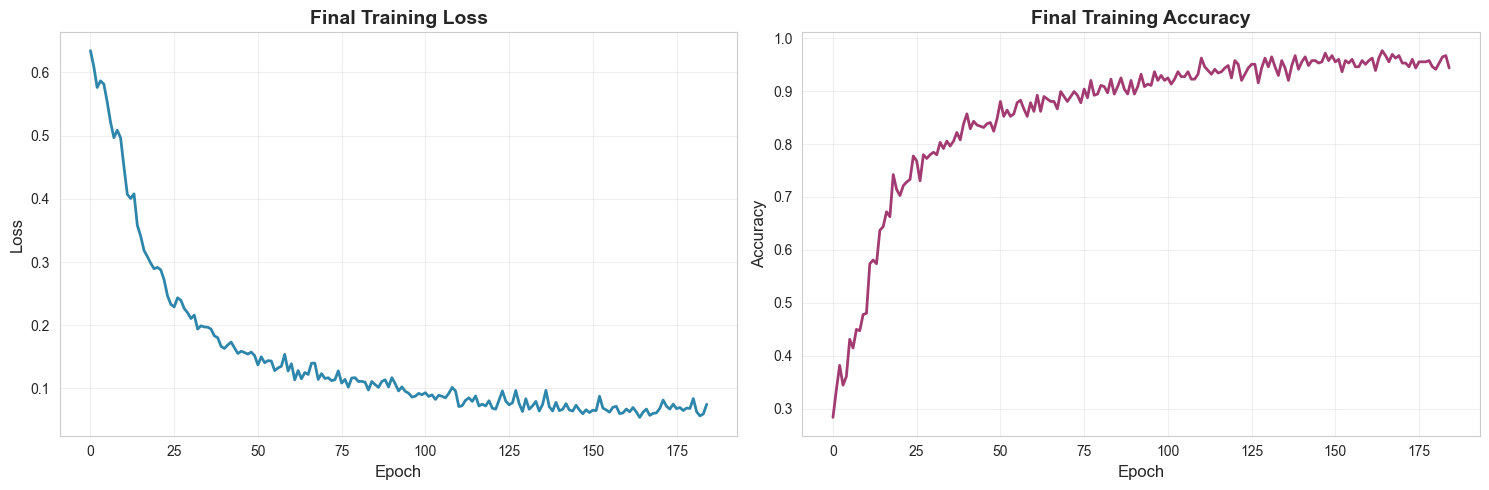

In [146]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(final_train_losses, linewidth=2, color='#2E86AB')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Final Training Loss', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
plt.plot(final_train_accs, linewidth=2, color='#A23B72')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Final Training Accuracy', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(model_dir / 'final_training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [147]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
all_preds = []
all_labels = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = final_model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())
test_accuracy = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

Test Accuracy: 0.8684
Test F1 Score: 0.8669



Classification Report:
              precision    recall  f1-score   support

         Low       0.93      0.93      0.93        40
      Medium       0.80      0.86      0.83        28
        High       0.83      0.62      0.71         8

    accuracy                           0.87        76
   macro avg       0.85      0.80      0.82        76
weighted avg       0.87      0.87      0.87        76



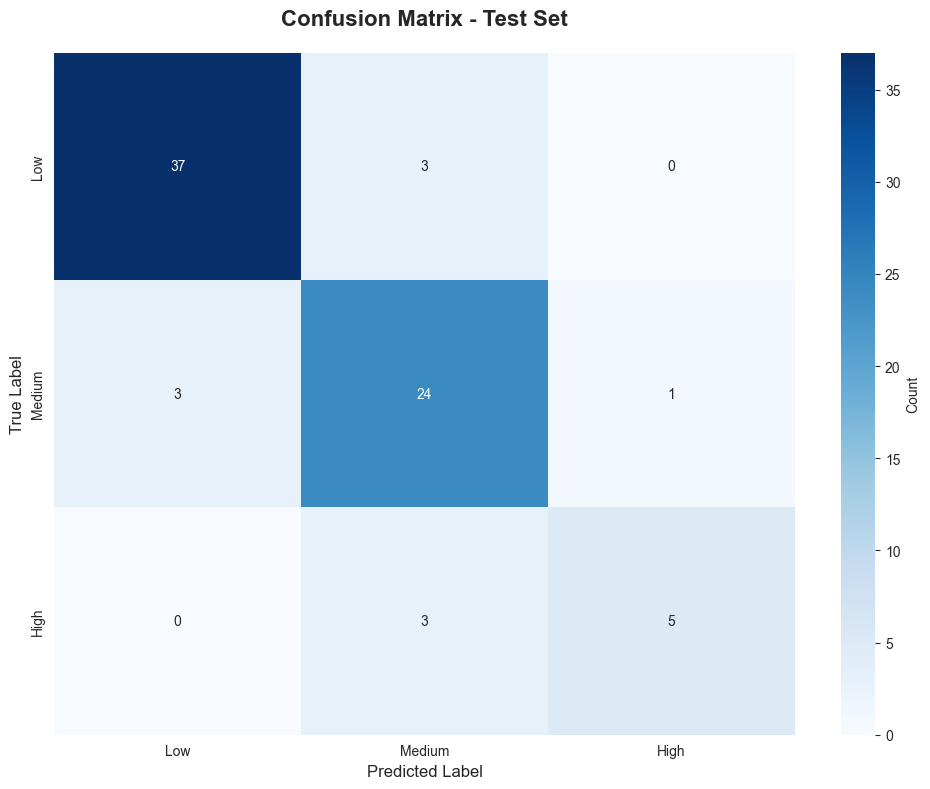


Confusion matrix saved to ..\models\confusion_matrix.png


In [148]:
class_names = ['Low', 'Medium', 'High']
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=16, fontweight='bold', pad=20)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(model_dir / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\nConfusion matrix saved to {model_dir / 'confusion_matrix.png'}")

In [149]:
torch.save({
    'model_state_dict': final_model.state_dict(),
    'model_architecture': {
        'input_dim': input_dim,
        'hidden_dims': hidden_dims,
        'num_classes': num_classes,
        'dropout': 0.5
    },
    'best_config': best_config,
    'scaler_params': {
        'mean': scaler.mean_.tolist(),
        'scale': scaler.scale_.tolist()
    },
    'feature_columns': feature_cols,
    'label_mapping': label_mapping,
    'test_accuracy': test_accuracy,
    'test_f1_score': test_f1
}, model_dir / 'esg_risk_model.pt')
print(f"Model saved to {model_dir / 'esg_risk_model.pt'}")

Model saved to ..\models\esg_risk_model.pt


In [150]:
joblib.dump(scaler, model_dir / 'scaler.pkl')
print(f"Scaler saved to {model_dir / 'scaler.pkl'}")

Scaler saved to ..\models\scaler.pkl


In [151]:
metadata = {
    'model_type': 'ESGRiskClassifier',
    'input_features': len(feature_cols),
    'num_classes': num_classes,
    'class_names': class_names,
    'training_samples': len(X_train),
    'validation_samples': len(X_val),
    'test_samples': len(X_test),
    'test_accuracy': float(test_accuracy),
    'test_f1_score': float(test_f1),
    'best_hyperparameters': best_config,
    'feature_columns': feature_cols,
    'label_mapping': label_mapping,
    'architecture': {
        'input_dim': input_dim,
        'hidden_dims': hidden_dims,
        'num_classes': num_classes,
        'dropout': 0.5
    },
    'training_improvements': {
        'scheduler': 'OneCycleLR',
        'label_smoothing': 0.1,
        'focal_loss_gamma': 2.0,
        'gradient_clipping': 1.0,
        'model_checkpointing': True
    },
    'training_date': datetime.now().isoformat()
}
with open(model_dir / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Metadata saved to {model_dir / 'model_metadata.json'}")


Metadata saved to ..\models\model_metadata.json


In [152]:
print("\n" + "="*70)
print("✨ TRAINING COMPLETE WITH IMPROVEMENTS ✨")
print("="*70)
print(f"📊 Final Test Accuracy: {test_accuracy:.4f}")
print(f"📊 Final Test F1 Score: {test_f1:.4f}")
print(f"\n🔧 Best Configuration: {best_config}")
print(f"\n🚀 Improvements Applied:")
print(f"   • OneCycleLR Scheduler (faster convergence)")
print(f"   • Label Smoothing (0.1) (better generalization)")
print(f"   • Model Checkpointing (saves best model)")
print(f"   • Training Visualization (saved plots)")
print(f"\n💾 Model saved at: {model_dir / 'esg_risk_model.pt'}")
print(f"📈 Plots saved:")
print(f"   • {model_dir / 'training_curves.png'}")
print(f"   • {model_dir / 'final_training_curves.png'}")
print(f"   • {model_dir / 'confusion_matrix.png'}")
print("="*70)


✨ TRAINING COMPLETE WITH IMPROVEMENTS ✨
📊 Final Test Accuracy: 0.8684
📊 Final Test F1 Score: 0.8669

🔧 Best Configuration: {'batch_size': 64, 'learning_rate': 0.0001, 'weight_decay': 0.0005, 'num_epochs': 150}

🚀 Improvements Applied:
   • OneCycleLR Scheduler (faster convergence)
   • Label Smoothing (0.1) (better generalization)
   • Model Checkpointing (saves best model)
   • Training Visualization (saved plots)

💾 Model saved at: ..\models\esg_risk_model.pt
📈 Plots saved:
   • ..\models\training_curves.png
   • ..\models\final_training_curves.png
   • ..\models\confusion_matrix.png


In [153]:
try:
    metadata['threshold_optimization'] = {
        'default_threshold': 0.33,
        'optimal_threshold_80pct_recall': float(optimal_threshold),
        'high_risk_recall_at_optimal': float(optimal_recall),
        'high_risk_precision_at_optimal': float(optimal_precision),
        'recommendation': f'Use threshold {optimal_threshold:.2f} for High risk class in production'
    }
    print(f"✅ Updated metadata with threshold optimization results")
except NameError:
    print("⚠️  Threshold optimization not run yet. Run the analysis cells below first, then re-run this cell.")
    metadata['threshold_optimization'] = {
        'status': 'not_computed',
        'note': 'Run threshold optimization cells to compute optimal thresholds'
    }
with open(model_dir / 'model_metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"💾 Metadata saved to {model_dir / 'model_metadata.json'}")

✅ Updated metadata with threshold optimization results
💾 Metadata saved to ..\models\model_metadata.json


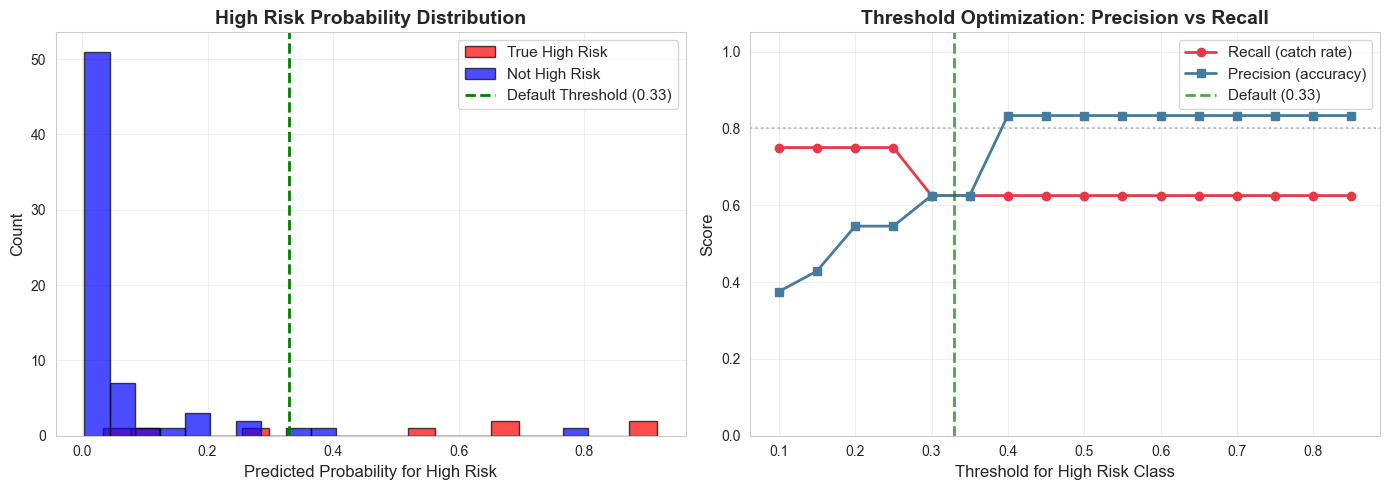


🎯 Threshold Optimization Results:
   Current threshold: 0.33 → High Risk Recall: 62.50%
   Optimal threshold: 0.10 → High Risk Recall: 75.00%, Precision: 37.50%
   Recommendation: Lower threshold to 0.10 for production to catch more high-risk cases


In [154]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
all_probs = []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        outputs = final_model(batch_X)
        probs = torch.softmax(outputs, dim=1)
        all_probs.extend(probs.cpu().numpy())
all_probs = np.array(all_probs)
high_class_idx = 2  # High is class 2
high_class_probs = all_probs[:, high_class_idx]
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
true_high = np.array(all_labels) == high_class_idx
plt.hist(high_class_probs[true_high], bins=20, alpha=0.7, label='True High Risk', color='red', edgecolor='black')
plt.hist(high_class_probs[~true_high], bins=20, alpha=0.7, label='Not High Risk', color='blue', edgecolor='black')
plt.axvline(x=0.33, color='green', linestyle='--', linewidth=2, label='Default Threshold (0.33)')
plt.xlabel('Predicted Probability for High Risk', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('High Risk Probability Distribution', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.subplot(1, 2, 2)
thresholds = np.arange(0.1, 0.9, 0.05)
recalls = []
precisions = []
for threshold in thresholds:
    adjusted_preds = []
    for prob_row in all_probs:
        if prob_row[high_class_idx] >= threshold:
            adjusted_preds.append(high_class_idx)
        else:
            adjusted_preds.append(np.argmax(prob_row))
    high_mask = np.array(all_labels) == high_class_idx
    high_recall = np.mean(np.array(adjusted_preds)[high_mask] == high_class_idx)
    high_pred_mask = np.array(adjusted_preds) == high_class_idx
    if high_pred_mask.sum() > 0:
        high_precision = np.mean(np.array(all_labels)[high_pred_mask] == high_class_idx)
    else:
        high_precision = 0
    recalls.append(high_recall)
    precisions.append(high_precision)
plt.plot(thresholds, recalls, 'o-', linewidth=2, markersize=6, label='Recall (catch rate)', color='#E63946')
plt.plot(thresholds, precisions, 's-', linewidth=2, markersize=6, label='Precision (accuracy)', color='#457B9D')
plt.axvline(x=0.33, color='green', linestyle='--', linewidth=2, alpha=0.7, label='Default (0.33)')
plt.axhline(y=0.8, color='gray', linestyle=':', alpha=0.5)
plt.xlabel('Threshold for High Risk Class', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.title('Threshold Optimization: Precision vs Recall', fontsize=14, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.ylim([0, 1.05])
plt.tight_layout()
plt.savefig(model_dir / 'high_risk_analysis.png', dpi=150, bbox_inches='tight')
plt.show()
optimal_threshold = thresholds[np.argmin([abs(r - 0.8) for r in recalls])]
optimal_recall = recalls[np.argmin([abs(r - 0.8) for r in recalls])]
optimal_precision = precisions[np.argmin([abs(r - 0.8) for r in recalls])]
print(f"\n🎯 Threshold Optimization Results:")
print(f"   Current threshold: 0.33 → High Risk Recall: {recalls[4]:.2%}")
print(f"   Optimal threshold: {optimal_threshold:.2f} → High Risk Recall: {optimal_recall:.2%}, Precision: {optimal_precision:.2%}")
print(f"   Recommendation: Lower threshold to {optimal_threshold:.2f} for production to catch more high-risk cases")


In [155]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1, support = precision_recall_fscore_support(all_labels, all_preds)
print("\n📊 Detailed Per-Class Analysis:")
print("="*60)
for i, class_name in enumerate(class_names):
    print(f"\n{class_name} Risk Class:")
    print(f"  • Samples: {support[i]}")
    print(f"  • Precision: {precision[i]:.3f} (of predicted {class_name}, {precision[i]*100:.1f}% are correct)")
    print(f"  • Recall: {recall[i]:.3f} (catches {recall[i]*100:.1f}% of actual {class_name} cases)")
    print(f"  • F1-Score: {f1[i]:.3f}")
    if recall[i] < 0.75 and class_name == 'High':
        print(f"  ⚠️  WARNING: Low recall for {class_name} class - missing {(1-recall[i])*100:.1f}% of high-risk cases!")
print("\n" + "="*60)


📊 Detailed Per-Class Analysis:

Low Risk Class:
  • Samples: 40
  • Precision: 0.925 (of predicted Low, 92.5% are correct)
  • Recall: 0.925 (catches 92.5% of actual Low cases)
  • F1-Score: 0.925

Medium Risk Class:
  • Samples: 28
  • Precision: 0.800 (of predicted Medium, 80.0% are correct)
  • Recall: 0.857 (catches 85.7% of actual Medium cases)
  • F1-Score: 0.828

High Risk Class:
  • Samples: 8
  • Precision: 0.833 (of predicted High, 83.3% are correct)
  • Recall: 0.625 (catches 62.5% of actual High cases)
  • F1-Score: 0.714
  ⚠️  WARNING: Low recall for High class - missing 37.5% of high-risk cases!

